## Simple example of the EGCI calculation

juancolonna@icomp.ufam.edu.br

In [4]:
import numpy as np
from infromation_theory_utils import JSD, Entropy
import pandas as pd
import soundfile as sf
import os
from scipy.linalg import svd, toeplitz
from scipy.stats import zscore
from statsmodels.tsa.stattools import acf
from scipy.signal import spectrogram
import time
    
import matplotlib.pyplot as plt
%matplotlib inline

# Import packages related to downsampling 
import samplerate 
import resampy
import scipy.signal as scipy_signal
import math

# Import packages related to filtering
from scipy.io import wavfile
import os
import matplotlib.pyplot as plt
import aasi_filters as filters
from scipy.signal import butter, lfilter

## Introduction

This notebook shows the differences between the ECI curves with varying downsampling techniques and use of different filters for some audio records found into GRABADOR-SDZG-AM-15 and GRABADOR-SDZG-AM-15 folder. This is to validate if the ECI curve will capture rain data accurately. These recordings have a maximum frequency of 384kHz which require them to be downsampled.

Note: The splitting the audio files into 5 seconds is giving me many errors. 

### Loading the upper and lower boundaries

First, we have to choose the maximum time lag. Possible precalculated values are [32, 64, 128, 256, 512]. Other values are also possible, but the boundaries must be generated for these specific values using the script available at "generates_HxC_boundaries.ipynb"

In [5]:
lag = 512
cotas = pd.read_csv('./boundary_files/Cotas_HxC_bins_' + str(int(lag)) + '.csv')
noise = pd.read_csv('./coloredNoises/coloredNoises_' + str(int(lag)) + '.csv')

# Known files with rain in them
datapath = "./Rain/" 
# datapath = "./Sample_Data/"

# From external hard drive: 
# datapath = "/Volumes/Elements/Mixed_AM_Dataset2/"

### Plotting one audio sample in .wav format

In [7]:
#datapath = './GRABADOR-SDZG-AM-15/'
#Seems to have errors when switching from mono to stereo data.
#datapath = 'C:/Users/Jacob/Desktop/Bioacoustics Project/ClusteredData/Clusters_GY01/Clusters_GY01/cluster_12/'
#datapath = "C:/Users/Jacob/Desktop/Bioacoustics Project/AudioMothData/GRABADOR-SDZG-AM-16/"
#datapath = "./Sample_Data/"
#x, fs = sf.read(datapath + '20190611_202000.WAV')
#x, fs = sf.read(datapath + '108.wav')
#x, fs = sf.read(datapath + '20190613_082000.WAV')

# For Rain or Sample_Data file:
x, fs = sf.read(datapath + '20190614_110000.WAV')

# For Mixed Dataset 2: 
# x, fs = sf.read(datapath + '5D0EAE40.WAV')

downsampling_rate = 44100
original_rate = 384000
conversion_method = 'sinc_best'
rate_ratio = downsampling_rate/original_rate 
# print(rate_ratio)
x = zscore(x)

nfft = 1024 # allowed values = {64, 128, 256, 512, 1024, 2048}

# Power spectral density                      
f, t, Pxx = spectrogram(x, fs, nfft = nfft, nperseg = nfft, noverlap = nfft/2, window = 'hann', scaling = 'density')

# ### Removed plot figure for now ###
# plt.figure(figsize=(18,10))

# plt.subplot(2,1,1)
# plt.plot(x)
# plt.xlim([0,len(x)])
# plt.ylabel('Amplitude [V]')
# plt.xlabel('Time [sec]')

# plt.subplot(2,1,2)
# plt.pcolormesh(t, f, np.log(Pxx))
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# # cb = plt.colorbar() # uncomment to see the colorbar
# # cb.set_label('Power Spectral Density [dB]')
# plt.show()

### EGCI

Reading and processing all files in the folder and executing the steps of the algorithm described in the article https://www.biorxiv.org/content/10.1101/2020.02.09.940916v1

#### 1) Original Signal
Reference: https://pypi.org/project/samplerate/

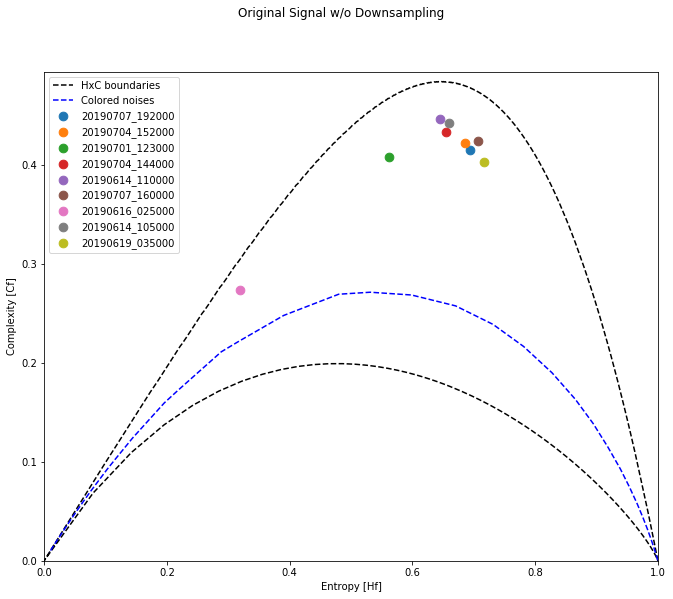

In [9]:
listing = os.listdir(datapath)

H = []
C = []
labels = []

#additional functionality to 
#f = open("./ECIComputerTimes.txt","w+")

for file in listing:
#    start = time.time()
    x, fs = sf.read(datapath + file)
    x = zscore(x) 
    
    # Algorithm steps 
    #Auto-Correlation Matrix
    rxx = acf(x, nlags=lag, unbiased=True, fft=True)
    Sxx = toeplitz(rxx)
    
    #Singular Value Decomposition
    U, s, Vt = svd(Sxx)
    
    H.append(Entropy(s))              # Entropy
    C.append(Entropy(s)*JSD(s))       # Complexity, also called EGCI index
    labels.append(file.split('.')[0])  # Species name originally but files name now
# time_in_seconds = time.time() - before
# print(f'{time_in_seconds:.3f}')

### Plotting the HxC plane ###
plt.figure(figsize=(11,9))

for i in range(len(H)):
    plt.scatter(H[i], C[i], marker='.', s=300, label = labels[i])
    plt.suptitle('Original Signal w/o Downsampling')
    
plt.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
plt.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
plt.xlim([0, 1])
plt.ylim([0, np.max(cotas['Complexity'])+0.01])
plt.ylabel('Complexity [Cf]')
plt.xlabel('Entropy [Hf]')
plt.legend(loc = 'best')
plt.show() #not necessary for jupyter notebook, necessary for terminal/scripts

Observations: The two rain files (20190614_105000.WAV, 20190614_110000.WAV) do not hug close to the blue curve. The rest of the curves are clustered close to each other. The original rain data sets, 20190614_105000.WAV and 20190614_110000.WAV match up with the original signal. 

### Import relevant functions

In [12]:
""" 
Some functions taken from section called Split 
Audio Data from File: Audio Data Visualization
by Erika Joun

Added samplerate input parameter to functions
"""
from scipy.io.wavfile import write
original_rate = 384000 # Also, defined in above code

# Get n-second clips
def split_into_n_seconds(wav_data, samplerate, n=5):
    length_in_seconds = len(wav_data) / samplerate
#     print(length_in_seconds)
    length_in_minutes = length_in_seconds / 60
#     print(length_in_minutes)
#     length_in_minutes = int(length_in_minutes)
#     print(length_in_minutes)
    shorter_len = int(round(length_in_minutes / (1/(60/n))))
    print(shorter_len)
    second_clips = None
    
    try:  
#         print(type(wav_data))
#         print(type(shorter_len))
        second_clips = np.split(wav_data, shorter_len)
        
    except: # Figure out what this exception error is for
        cut_wav_data = wav_data[:-((len(wav_data)) % shorter_len)]
        second_clips = np.split(cut_wav_data, shorter_len)

    print('%d %d-second clips' % (len(second_clips), n))
    return second_clips

# Saves clip as a wav file
def save_clip(filename, wav_array, samplerate):
    #assert('.' not in filename)
    write(filename + '.wav', samplerate, wav_array)
    
# Saves all clips to a directory
def save_clips_to_dir(shorter_clips, dirname, samplerate):
    for i, clip in enumerate(shorter_clips):
        save_clip(dirname + '/%d' % i, clip, samplerate)
    # Save clip as the file name
    
## FILTERING FUNCTIONS ###
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def make_txt_file(lists, path): 
    """ 
    Makes .txt file given list of filenames (labels)
    into the given directory name.
    """
    completeName = os.path.join(path, 'List_of_Rain.txt')
    file1 = open(completeName, 'w')
    file1.writelines(["%s\n" % item  for item in lists])

#### 1a) Samplerate Technique (downsampling only)
Reference: https://pypi.org/project/samplerate/

In [15]:
listing = os.listdir(datapath)

H = []
C = []
labels = []

#additional functionality to 
#f = open("./ECIComputerTimes.txt","w+")

for file in listing:
#    start = time.time()
    x, fs = sf.read(datapath + file)
    x = zscore(x) 
    
### DOWNSAMPLING ### 
    # 1) Samplerate 
    # https://pypi.org/project/samplerate/
    x = samplerate.resample(x, rate_ratio, conversion_method)
    
    # Algorithm steps 
    #Auto-Correlation Matrix
    rxx = acf(x, nlags=lag, unbiased=True, fft=True)
    Sxx = toeplitz(rxx)
    
    #Singular Value Decomposition
    U, s, Vt = svd(Sxx)
    
    H.append(Entropy(s))              # Entropy
    C.append(Entropy(s)*JSD(s))       # Complexity, also called EGCI index
    labels.append(file.split('.')[0])  # Species name

#    end = time.time()
#    f.write(file + ": " + str(round(end - start,3)) + "\n")
#    f.close()

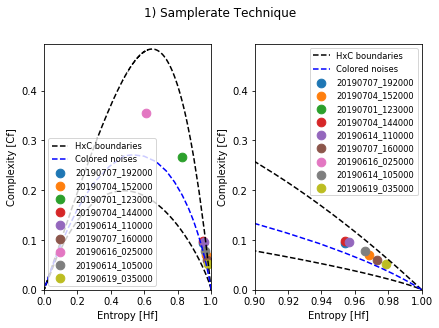

In [16]:
### Plotting the HxC plane ###
fig, (ax1, ax2) = plt.subplots(1, 2)

for i in range(len(H)):
#### 1a) Samplerate Technique (downsampling only)
    fig.suptitle('1) Samplerate Technique', y=1.08)
    fig.tight_layout()
    ax1.scatter(H[i], C[i], marker='.', s=300, label = labels[i])
    ax2.scatter(H[i], C[i], marker='.', s=300, label = labels[i])

ax1.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax1.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, np.max(cotas['Complexity'])+0.01])
ax1.set_ylabel('Complexity [Cf]')
ax1.set_xlabel('Entropy [Hf]')
ax1.legend(loc = 'lower left', fontsize='small')
    
ax2.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax2.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
ax2.set_xlim([0.9, 1])
ax2.set_ylim([0, np.max(cotas['Complexity'])+0.01])
ax2.set_ylabel('Complexity [Cf]')
ax2.set_xlabel('Entropy [Hf]')
ax2.legend(loc = 'best', fontsize='small')

#### 1b) Samplerate Technique (low pass filter & downsampling)
Reference: https://pypi.org/project/samplerate/

In [17]:
listing = os.listdir(datapath)

H = []
C = []
labels = []

#additional functionality to 
#f = open("./ECIComputerTimes.txt","w+")

for file in listing:
#    start = time.time()
    x, fs = sf.read(datapath + file)
    x = zscore(x) 
    
    ### FILTERING ###
    fcutoff = 22050
    order = 2 
    is_stereo = len(x.shape) == 2
    sosfilter = filters.design_lowpass_butter_filter(fcutoff, order, fs, sos=True)
    filt_data_sos = filters.filter(x, sosfilter, stereo=is_stereo)
    x = filt_data_sos

    ### DOWNSAMPLING ### 
    # 1) Samplerate 
    # https://pypi.org/project/samplerate/

    # Change the rate_ratio here: 
    downsampled_signal = samplerate.resample(x, rate_ratio, conversion_method, 1)
    x = downsampled_signal

    # Algorithm steps 
    #Auto-Correlation Matrix
    rxx = acf(x, nlags=lag, unbiased=True, fft=True)
    Sxx = toeplitz(rxx)

    #Singular Value Decomposition
    U, s, Vt = svd(Sxx)

    H.append(Entropy(s))              # Entropy
    C.append(Entropy(s)*JSD(s))       # Complexity, also called EGCI index
    labels.append(file.split('.')[0])  # Species name

#    end = time.time()
#    f.write(file + ": " + str(round(end - start,3)) + "\n")
#    f.close()

samplerate info:
23040000 input frames used
2645999 output frames generated

samplerate info:
23040000 input frames used
2645999 output frames generated

samplerate info:
23040000 input frames used
2645999 output frames generated

samplerate info:
23040000 input frames used
2645999 output frames generated

samplerate info:
23040000 input frames used
2645999 output frames generated

samplerate info:
23040000 input frames used
2645999 output frames generated

samplerate info:
23040000 input frames used
2645999 output frames generated

samplerate info:
23040000 input frames used
2645999 output frames generated

samplerate info:
23040000 input frames used
2645999 output frames generated



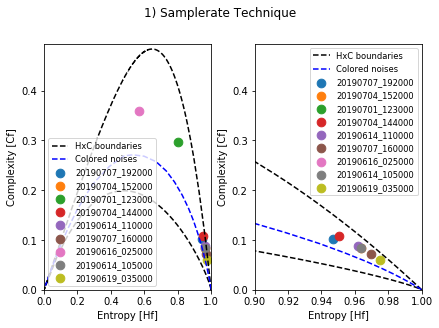

In [18]:
### Plotting the HxC plane ###
fig, (ax1, ax2) = plt.subplots(1, 2)

for i in range(len(H)):
    fig.suptitle('1) Samplerate Technique', y=1.08)
    fig.tight_layout()
    ax1.scatter(H[i], C[i], marker='.', s=300, label = labels[i])
    ax2.scatter(H[i], C[i], marker='.', s=300, label = labels[i])

    
ax1.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax1.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, np.max(cotas['Complexity'])+0.01])
ax1.set_ylabel('Complexity [Cf]')
ax1.set_xlabel('Entropy [Hf]')
ax1.legend(loc = 'lower left', fontsize='small')
    
ax2.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax2.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
ax2.set_xlim([0.9, 1])
ax2.set_ylim([0, np.max(cotas['Complexity'])+0.01])
ax2.set_ylabel('Complexity [Cf]')
ax2.set_xlabel('Entropy [Hf]')
ax2.legend(loc = 'best', fontsize='small')

#### 1c) Samplerate Technique (band pass & downsampling)
Reference: https://pypi.org/project/samplerate/

In [23]:
listing = os.listdir(datapath)

H = []
C = []
labels = []

#additional functionality to 
#f = open("./ECIComputerTimes.txt","w+")

### FILTERING ###
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


for file in listing:
#    start = time.time()
    x, fs = sf.read(datapath + file)
    x = zscore(x) 
    
    # TO DO: need to figure out error when I split the audio file
    
    ### FILTERING ###
    # Sample rate and desired cutoff frequencies (in Hz).
    lowcut = 1000
    highcut = 22000
    x = butter_bandpass_filter(x, lowcut, highcut, fs, order=2)

    ### DOWNSAMPLING ### 
    # 1) Samplerate 
    # https://pypi.org/project/samplerate/

    # Change the rate_ratio here: 
    x = samplerate.resample(x, rate_ratio, conversion_method, 1)

    # Algorithm steps 
    #Auto-Correlation Matrix
    rxx = acf(x, nlags=lag, unbiased=True, fft=True)
    Sxx = toeplitz(rxx)

    #Singular Value Decomposition
    U, s, Vt = svd(Sxx)

    H.append(Entropy(s))              # Entropy
    C.append(Entropy(s)*JSD(s))       # Complexity, also called EGCI index
    labels.append(file.split('.')[0])  # Species name

samplerate info:
23040000 input frames used
2645999 output frames generated

samplerate info:
23040000 input frames used
2645999 output frames generated

samplerate info:
23040000 input frames used
2645999 output frames generated

samplerate info:
23040000 input frames used
2645999 output frames generated

samplerate info:
23040000 input frames used
2645999 output frames generated

samplerate info:
23040000 input frames used
2645999 output frames generated

samplerate info:
23040000 input frames used
2645999 output frames generated

samplerate info:
23040000 input frames used
2645999 output frames generated

samplerate info:
23040000 input frames used
2645999 output frames generated



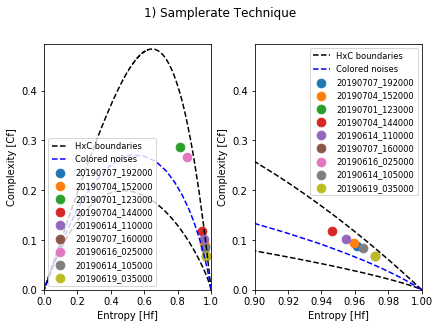

In [24]:
### Plotting the HxC plane ###
fig, (ax1, ax2) = plt.subplots(1, 2)

for i in range(len(H)):
    fig.suptitle('1) Samplerate Technique', y=1.08)
    fig.tight_layout()
    ax1.scatter(H[i], C[i], marker='.', s=300, label = labels[i])
    ax2.scatter(H[i], C[i], marker='.', s=300, label = labels[i])

    
ax1.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax1.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, np.max(cotas['Complexity'])+0.01])
ax1.set_ylabel('Complexity [Cf]')
ax1.set_xlabel('Entropy [Hf]')
ax1.legend(loc = 'lower left', fontsize='small')
    
ax2.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax2.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
ax2.set_xlim([0.9, 1])
ax2.set_ylim([0, np.max(cotas['Complexity'])+0.01])
ax2.set_ylabel('Complexity [Cf]')
ax2.set_xlabel('Entropy [Hf]')
ax2.legend(loc = 'best', fontsize='small')

#### 2a) Scipy's built in resample function (downsampling only)
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html

In [27]:
listing = os.listdir(datapath)

H = []
C = []
labels = []

#additional functionality to 
#f = open("./ECIComputerTimes.txt","w+")

for file in listing:
#    start = time.time()
    x, fs = sf.read(datapath + file)
    x = zscore(x) 

### DOWNSAMPLING ### 

    # 2) Scipy's built in resample function 
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html
    x = scipy_signal.resample(x, int(len(x)*rate_ratio))
    
    # Algorithm steps 
    #Auto-Correlation Matrix
    rxx = acf(x, nlags=lag, unbiased=True, fft=True)
    Sxx = toeplitz(rxx)
    
    #Singular Value Decomposition
    U, s, Vt = svd(Sxx)
    
    H.append(Entropy(s))              # Entropy
    C.append(Entropy(s)*JSD(s))       # Complexity, also called EGCI index
    labels.append(file.split('.')[0])  # Species name

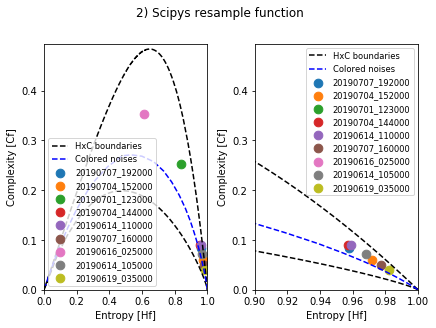

In [28]:
### Plotting the HxC plane ()###
fig, (ax1, ax2) = plt.subplots(1, 2)

for i in range(len(H)):
    fig.suptitle('2) Scipys resample function', y=1.08)
    fig.tight_layout()
    ax1.scatter(H[i], C[i], marker='.', s=300, label = labels[i])
    ax2.scatter(H[i], C[i], marker='.', s=300, label = labels[i])
    
ax1.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax1.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, np.max(cotas['Complexity'])+0.01])
ax1.set_ylabel('Complexity [Cf]')
ax1.set_xlabel('Entropy [Hf]')
ax1.legend(loc = 'lower left', fontsize='small')

ax2.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax2.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
ax2.set_xlim([0.9, 1])
ax2.set_ylim([0, np.max(cotas['Complexity'])+0.01])
ax2.set_ylabel('Complexity [Cf]')
ax2.set_xlabel('Entropy [Hf]')
ax2.legend(loc = 'best', fontsize='small')

#### 2b) Scipy's built in resample function (low pass filter & downsampling)
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html

In [29]:
listing = os.listdir(datapath)

H = []
C = []
labels = []

#additional functionality to 
#f = open("./ECIComputerTimes.txt","w+")

for file in listing:
#    start = time.time()
    x, fs = sf.read(datapath + file)
    x = zscore(x) 

    ### FILTERING ###
    fcutoff = 22050
    order = 2 
    is_stereo = len(x.shape) == 2
    sosfilter = filters.design_lowpass_butter_filter(fcutoff, order, fs, sos=True)
    x = filters.filter(x, sosfilter, stereo=is_stereo)

    ### DOWNSAMPLING ### 
    # 2) Scipy's built in resample function 
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html
    x = scipy_signal.resample(x, int(len(x)*rate_ratio))

    # Algorithm steps 
    #Auto-Correlation Matrix
    rxx = acf(x, nlags=lag, unbiased=True, fft=True)
    Sxx = toeplitz(rxx)

    #Singular Value Decomposition
    U, s, Vt = svd(Sxx)

    H.append(Entropy(s))              # Entropy
    C.append(Entropy(s)*JSD(s))       # Complexity, also called EGCI index
    labels.append(file.split('.')[0])  # Species name

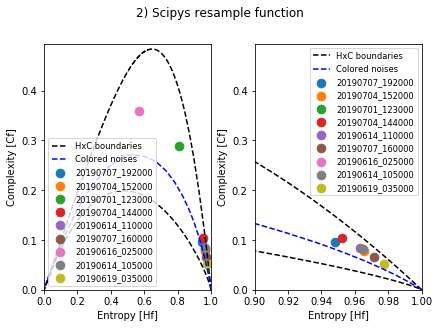

In [30]:
### Plotting the HxC plane ()###
fig, (ax1, ax2) = plt.subplots(1, 2)

for i in range(len(H)):
    fig.suptitle('2) Scipys resample function', y=1.08)
    fig.tight_layout()
    ax1.scatter(H[i], C[i], marker='.', s=300, label = labels[i])
    ax2.scatter(H[i], C[i], marker='.', s=300, label = labels[i])
    
ax1.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax1.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, np.max(cotas['Complexity'])+0.01])
ax1.set_ylabel('Complexity [Cf]')
ax1.set_xlabel('Entropy [Hf]')
ax1.legend(loc = 'lower left', fontsize='small')

ax2.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax2.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
ax2.set_xlim([0.9, 1])
ax2.set_ylim([0, np.max(cotas['Complexity'])+0.01])
ax2.set_ylabel('Complexity [Cf]')
ax2.set_xlabel('Entropy [Hf]')
ax2.legend(loc = 'best', fontsize='small')

#### 2c) Scipy's built in resample function (band pass & downsampling)
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html

In [31]:
listing = os.listdir(datapath)

H = []
C = []
labels = []

#additional functionality to 
#f = open("./ECIComputerTimes.txt","w+")

### FILTERING ###
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

for file in listing:
#    start = time.time()
    x, fs = sf.read(datapath + file)
    x = zscore(x) 

    # Sample rate and desired cutoff frequencies (in Hz).
    lowcut = 1000
    highcut = 22000
    x = butter_bandpass_filter(x, lowcut, highcut, fs, order=2)

    ### DOWNSAMPLING ### 
    # 2) Scipy's built in resample function 
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html
    x = scipy_signal.resample(x, int(len(x)*rate_ratio))

    # Algorithm steps 
    #Auto-Correlation Matrix
    rxx = acf(x, nlags=lag, unbiased=True, fft=True)
    Sxx = toeplitz(rxx)

    #Singular Value Decomposition
    U, s, Vt = svd(Sxx)

    H.append(Entropy(s))              # Entropy
    C.append(Entropy(s)*JSD(s))       # Complexity, also called EGCI index
    labels.append(file.split('.')[0])  # Species name

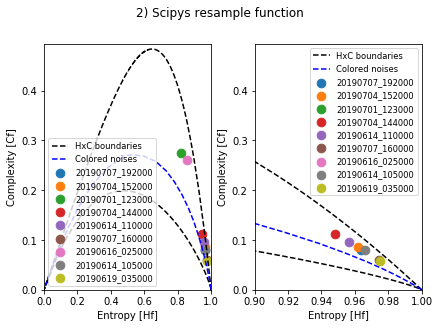

In [32]:
### Plotting the HxC plane ()###
fig, (ax1, ax2) = plt.subplots(1, 2)

for i in range(len(H)):
    fig.suptitle('2) Scipys resample function', y=1.08)
    fig.tight_layout()
    ax1.scatter(H[i], C[i], marker='.', s=300, label = labels[i])
    ax2.scatter(H[i], C[i], marker='.', s=300, label = labels[i])
    
ax1.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax1.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, np.max(cotas['Complexity'])+0.01])
ax1.set_ylabel('Complexity [Cf]')
ax1.set_xlabel('Entropy [Hf]')
ax1.legend(loc = 'lower left', fontsize='small')

ax2.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax2.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
ax2.set_xlim([0.9, 1])
ax2.set_ylim([0, np.max(cotas['Complexity'])+0.01])
ax2.set_ylabel('Complexity [Cf]')
ax2.set_xlabel('Entropy [Hf]')
ax2.legend(loc = 'best', fontsize='small')

#### 3a) Resampy Implementation (downsampling only)
Reference:https://resampy.readthedocs.io/en/master/example.html

In [33]:
listing = os.listdir(datapath)

H = []
C = []
labels = []

#additional functionality to 
#f = open("./ECIComputerTimes.txt","w+")

for file in listing:
#    start = time.time()
    x, fs = sf.read(datapath + file)
    x = zscore(x) 

    # 3) Resampy Implementation 
    # https://resampy.readthedocs.io/en/master/example.html
    x = resampy.resample(np.float64(x), original_rate, downsampling_rate)

    # Algorithm steps 
    #Auto-Correlation Matrix
    rxx = acf(x, nlags=lag, unbiased=True, fft=True)
    Sxx = toeplitz(rxx)

    #Singular Value Decomposition
    U, s, Vt = svd(Sxx)

    H.append(Entropy(s))              # Entropy
    C.append(Entropy(s)*JSD(s))       # Complexity, also called EGCI index
    labels.append(file.split('.')[0])  # Species name

Initial H
[0.949898083381814, 0.9647288981865656, 0.8176861976790598, 0.9508560833768522, 0.953033729632247, 0.9691351000874261, 0.6056027111019284, 0.9633028761410969, 0.9737808731055361]
Initial C
[0.10437242579343183, 0.08112786191993701, 0.27871132720182223, 0.10776381867450843, 0.10709034360873988, 0.07270638338105892, 0.3572993152602584, 0.08678526673462279, 0.06470789203522548]
Each C[i]:  0.10437242579343183
Each C[i]:  0.08112786191993701
Each C[i]:  0.27871132720182223
Each C[i]:  0.10776381867450843
Each C[i]:  0.10709034360873988
Each C[i]:  0.07270638338105892
Each C[i]:  0.3572993152602584
Each C[i]:  0.08678526673462279
Each C[i]:  0.06470789203522548
Final H
[0.949898083381814, 0.9647288981865656, 0.8176861976790598, 0.9508560833768522, 0.953033729632247, 0.9691351000874261, 0.6056027111019284, 0.9633028761410969, 0.9737808731055361]
Final C
[0.10437242579343183, 0.08112786191993701, 0.27871132720182223, 0.10776381867450843, 0.10709034360873988, 0.07270638338105892, 0.3

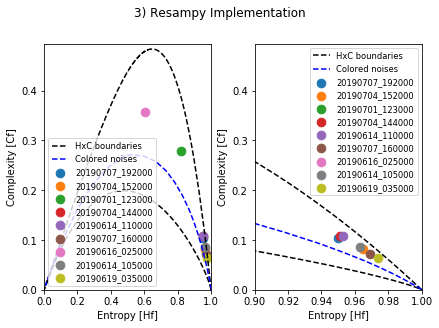

In [34]:
### Plotting the HxC plane ###
fig, (ax1, ax2) = plt.subplots(1, 2)

# print("Initial H")
# print(H) 
# print("Initial C")
# print(C)
for i in range(len(H)):
    fig.suptitle('3) Resampy Implementation', y=1.08)
    fig.tight_layout()
    ax1.scatter(H[i], C[i], marker='.', s=300, label = labels[i])
    ax2.scatter(H[i], C[i], marker='.', s=300, label = labels[i])
    print("Each C[i]: ", C[i])
    
# print("Final H")
# print(H)
# print("Final C")
# print(C)

ax1.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax1.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, np.max(cotas['Complexity'])+0.01])
ax1.set_ylabel('Complexity [Cf]')
ax1.set_xlabel('Entropy [Hf]')
ax1.legend(loc = 'lower left', fontsize='small')

ax2.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax2.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
ax2.set_xlim([0.9, 1])
ax2.set_ylim([0, np.max(cotas['Complexity'])+0.01])
ax2.set_ylabel('Complexity [Cf]')
ax2.set_xlabel('Entropy [Hf]')
ax2.legend(loc = 'best', fontsize='small')

#### 3b) Resampy Implementation (low pass filtering & downsampling)
Reference:https://resampy.readthedocs.io/en/master/example.html

In [35]:
listing = os.listdir(datapath)

H = []
C = []
labels = []

#additional functionality to 
#f = open("./ECIComputerTimes.txt","w+")

for file in listing:
#    start = time.time()
    x, fs = sf.read(datapath + file)
    x = zscore(x) 
    
    ### FILTERING ###

    fcutoff = 22050
    order = 2 
    is_stereo = len(x.shape) == 2
    sosfilter = filters.design_lowpass_butter_filter(fcutoff, order, fs, sos=True)
    x = filters.filter(x, sosfilter, stereo=is_stereo)

    ### DOWNSAMPLING ### 

    # 3) Resampy Implementation 
    # https://resampy.readthedocs.io/en/master/example.html
    x = resampy.resample(np.float64(x), original_rate, downsampling_rate)

    # Algorithm steps 
    #Auto-Correlation Matrix
    rxx = acf(x, nlags=lag, unbiased=True, fft=True)
    Sxx = toeplitz(rxx)

    #Singular Value Decomposition
    U, s, Vt = svd(Sxx)

    H.append(Entropy(s))              # Entropy
    C.append(Entropy(s)*JSD(s))       # Complexity, also called EGCI index
    labels.append(file.split('.')[0])  # Species name

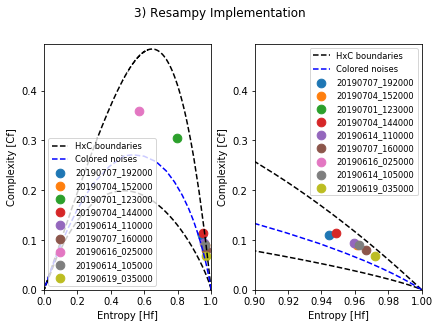

In [36]:
### Plotting the HxC plane ###
fig, (ax1, ax2) = plt.subplots(1, 2)

for i in range(len(H)):
    fig.suptitle('3) Resampy Implementation', y=1.08)
    fig.tight_layout()
    ax1.scatter(H[i], C[i], marker='.', s=300, label = labels[i])
    ax2.scatter(H[i], C[i], marker='.', s=300, label = labels[i])
    
ax1.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax1.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, np.max(cotas['Complexity'])+0.01])
ax1.set_ylabel('Complexity [Cf]')
ax1.set_xlabel('Entropy [Hf]')
ax1.legend(loc = 'lower left', fontsize='small')

ax2.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax2.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
ax2.set_xlim([0.9, 1])
ax2.set_ylim([0, np.max(cotas['Complexity'])+0.01])
ax2.set_ylabel('Complexity [Cf]')
ax2.set_xlabel('Entropy [Hf]')
ax2.legend(loc = 'best', fontsize='small')

#### 3c) Resampy Implementation (band pass filtering & downsampling)
Reference:https://resampy.readthedocs.io/en/master/example.html

In [37]:
listing = os.listdir(datapath)

H = []
C = []
labels = []

#additional functionality to 
#f = open("./ECIComputerTimes.txt","w+")

### FILTERING ###
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

for file in listing:
#    start = time.time()
    x, fs = sf.read(datapath + file)
    x = zscore(x) 

    # Sample rate and desired cutoff frequencies (in Hz).
    lowcut = 1000
    highcut = 22000
    x = butter_bandpass_filter(x, lowcut, highcut, fs, order=2)

    ### DOWNSAMPLING ### 

    # 3) Resampy Implementation 
    # https://resampy.readthedocs.io/en/master/example.html
    x = resampy.resample(np.float64(x), original_rate, downsampling_rate)

    # Algorithm steps 
    #Auto-Correlation Matrix
    rxx = acf(x, nlags=lag, unbiased=True, fft=True)
    Sxx = toeplitz(rxx)

    #Singular Value Decomposition
    U, s, Vt = svd(Sxx)

    H.append(Entropy(s))              # Entropy
    C.append(Entropy(s)*JSD(s))       # Complexity, also called EGCI index
    labels.append(file.split('.')[0])  # Species name

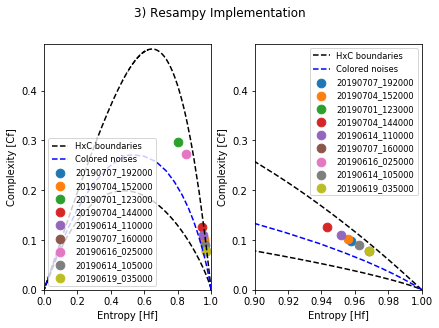

In [38]:
### Plotting the HxC plane ###
fig, (ax1, ax2) = plt.subplots(1, 2)

for i in range(len(H)):
    fig.suptitle('3) Resampy Implementation', y=1.08)
    fig.tight_layout()
    ax1.scatter(H[i], C[i], marker='.', s=300, label = labels[i])
    ax2.scatter(H[i], C[i], marker='.', s=300, label = labels[i])
    
ax1.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax1.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, np.max(cotas['Complexity'])+0.01])
ax1.set_ylabel('Complexity [Cf]')
ax1.set_xlabel('Entropy [Hf]')
ax1.legend(loc = 'lower left', fontsize='small')

ax2.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax2.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
ax2.set_xlim([0.9, 1])
ax2.set_ylim([0, np.max(cotas['Complexity'])+0.01])
ax2.set_ylabel('Complexity [Cf]')
ax2.set_xlabel('Entropy [Hf]')
ax2.legend(loc = 'best', fontsize='small')

## Final Filtering & Downsampling 

### Filtering and downsampling
#### Chose to use band pass and resampy Python library

20190610_022000.WAV
12
12 5-second clips
20190610_033000.WAV
12
12 5-second clips
20190610_043000.WAV
12
12 5-second clips
20190611_031000.WAV
12
12 5-second clips
20190611_035000.WAV
12
12 5-second clips
20190611_041000.WAV
12
12 5-second clips
20190611_044000.WAV
12
12 5-second clips
20190611_050000.WAV
12
12 5-second clips
20190611_054000.WAV
12
12 5-second clips
20190611_055000.WAV
12
12 5-second clips
20190611_063000.WAV
12
12 5-second clips
20190611_064000.WAV
12
12 5-second clips
20190611_072000.WAV
12
12 5-second clips
20190611_074000.WAV
12
12 5-second clips
20190611_080000.WAV
12
12 5-second clips
20190611_081000.WAV
12
12 5-second clips
20190611_084000.WAV
12
12 5-second clips
20190615_224000.WAV
12
12 5-second clips
20190615_231000.WAV
12
12 5-second clips
20190615_235000.WAV
12
12 5-second clips
20190616_004000.WAV
12
12 5-second clips
20190616_010000.WAV
12
12 5-second clips
20190616_013000.WAV
12
12 5-second clips
20190616_015000.WAV
12
12 5-second clips
20190616_020000.

20190701_200000.WAV
12
12 5-second clips
20190701_210000.WAV
12
12 5-second clips
20190702_030000.WAV
12
12 5-second clips
20190702_040000.WAV
12
12 5-second clips
20190702_051000.WAV
12
12 5-second clips
20190702_054000.WAV
12
12 5-second clips
20190702_055000.WAV
12
12 5-second clips
20190702_060000.WAV
12
12 5-second clips
20190702_063000.WAV
12
12 5-second clips
20190702_064000.WAV
12
12 5-second clips
20190702_071000.WAV
12
12 5-second clips
20190702_080000.WAV
12
12 5-second clips
20190704_032000.WAV
12
12 5-second clips
20190704_040000.WAV
12
12 5-second clips
20190704_041000.WAV
12
12 5-second clips
20190704_061000.WAV
12
12 5-second clips
20190704_070000.WAV
12
12 5-second clips
20190704_085000.WAV
12
12 5-second clips
20190704_090000.WAV
12
12 5-second clips
20190704_091000.WAV
12
12 5-second clips
20190704_092000.WAV
12
12 5-second clips
20190704_102000.WAV
12
12 5-second clips
20190704_111000.WAV
12
12 5-second clips
20190704_115000.WAV
12
12 5-second clips
20190704_130000.

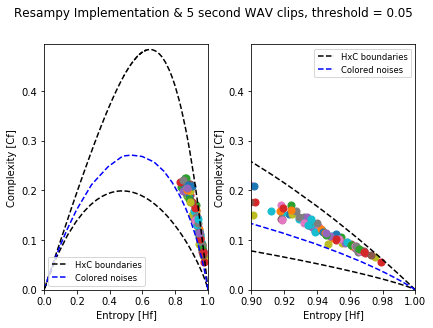

In [93]:
# Make sure to change the datapath
listing = os.listdir(datapath)

H = []
C = []
labels = []

# Threshold is bound to change
threshold = 0.05 

# Prevents randomization, comment out after debugging
# np.random.seed(0)

before = time.time()
for file in listing:
    # Could comment this out if it gets annoying
    print(file)
    x, fs = sf.read(datapath + file)
    x = zscore(x) # Make sure to do this before splitting the files
    
    ### SPLIT ###
    # Split files into 5 second audio clips 
    split_data = np.array(split_into_n_seconds(x, original_rate, 5))
    
    number_of_rows = split_data.shape[0]
    random_indices = np.random.choice(number_of_rows, size=1, replace=False)
    x = split_data[random_indices, :]
#     save_clips_to_dir(x, 'Test', original_rate)
    
    ## FILTERING ### 
    lowcut = 1000
    highcut = 22000
    x = butter_bandpass_filter(x, lowcut, highcut, fs, order=2)
      
    ### DOWNSAMPLING ### 
    # Just chose arbitrary downsampling method for now
    # 3) Resampy Implementation 
    # https://resampy.readthedocs.io/en/master/example.html
    x = resampy.resample(np.float64(x), original_rate, downsampling_rate)
#     print(x)
    
    # Algorithm steps 
    #Auto-Correlation Matrix
    rxx = acf(x, nlags=lag, unbiased=True, fft=True)
    Sxx = toeplitz(rxx)

    #Singular Value Decomposition
    U, s, Vt = svd(Sxx)

    H.append(Entropy(s))              # Entropy
    C.append(Entropy(s)*JSD(s))       # Complexity, also called EGCI index
    labels.append(file.split('.')[0])  # Species name

    
time_in_seconds = time.time() - before
print(f'{time_in_seconds:.3f}')
    
### Plotting the HxC plane ###
fig, (ax1, ax2) = plt.subplots(1, 2)

### Curve Fitting and Threshold ###
entropy_x = noise['Entropy'] #<class 'pandas.core.series.Series'>
complexity_y = noise['Complexity']

z = np.polyfit(entropy_x, complexity_y, 10, rcond=None, full=False, w=None, cov=False)
p = np.poly1d(z)

plt.ylim(0, 0.4)

labels_threshold = []
for i in range(len(H)):
    fig.suptitle('Resampy Implementation & 5 second WAV clips, threshold = ' + str(threshold), y=1.08)
    fig.tight_layout()
    y_new = p(C[i])
    diff = abs(C[i]-y_new)
    if (diff < threshold): 
#         ax1.scatter(H[i], C[i], marker='.', s=300, label = labels[i])
#         ax2.scatter(H[i], C[i], marker='.', s=300, label = labels[i])
        ax1.scatter(H[i], C[i], marker='.', s=200)
        ax2.scatter(H[i], C[i], marker='.', s=200)
        labels_threshold.append(labels[i])

make_txt_file(labels_threshold, "./Test/")
    
ax1.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax1.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, np.max(cotas['Complexity'])+0.01])
ax1.set_ylabel('Complexity [Cf]')
ax1.set_xlabel('Entropy [Hf]')
ax1.legend(loc = 'lower left', fontsize='small')

ax2.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
ax2.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
ax2.set_xlim([0.9, 1])
ax2.set_ylim([0, np.max(cotas['Complexity'])+0.01])
ax2.set_ylabel('Complexity [Cf]')
ax2.set_xlabel('Entropy [Hf]')
ax2.legend(loc = 'best', fontsize='small')